In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [2]:
#tensorflow keras dataset에서 가져온 데이타셋.
train_image = np.load('mnist_train_image.npy')
train_label = np.load('mnist_train_label.npy')

In [3]:
train_image.shape

(60000, 28, 28)

In [4]:
# 훈련 데이터 셔플
index = np.array(range(len(train_image)))
np.random.shuffle(index)
train_image = train_image[index]
train_label = train_label[index]

In [5]:
# 데이터 전처리 
train_image = (train_image -[128]) / 128

In [6]:
# 훈련데이터와 검증데이터 분리 
sp = int(5e4)
train_x = train_image[:sp]
train_y = train_label[:sp].astype(np.int32)
valid_x = train_image[sp:]
valid_y = train_label[sp:].astype(np.int32)

In [7]:
aa = train_x[0][:]

In [8]:
# 토치 텐서로 변환
train_x = torch.FloatTensor(train_x).view(-1,1, 28,28)
train_y = torch.LongTensor(train_y)
valid_x = torch.FloatTensor(valid_x).view(-1,1,28,28)
valid_y = torch.LongTensor(valid_y)

In [9]:
class net(torch.nn.Module):

    def __init__(self):
        super(net, self).__init__()
        
        #input (num_batch, channel=1, 28, 28)
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 4, stride=2, padding=1 #output (-1, 16, 13, 13) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride=2, padding=0) #output (-1,32, 6, 6)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=0 )  #output (-1, 64, 4,4)
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=0 )  #output (-1, 128, 2,2)
        self.fc    = nn.Linear(128*2*2, 10) 
        
    
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv3(x)) 
        x = F.relu(self.conv4(x))
        x = x.view(-1, 128 * 2 * 2) #벡터로 변환 
        x = self.fc(x)
        return x
    
    def predict(self, image):
        image = (image -[128])/128
        image = torch.from_numpy(image).float()
        image = image.view(-1,1, 28,28)
        out   = self.forward(image).view(-1)
        return out.argmax().item()
    
    def accuracy(self, input_data, target_data):
        predict = self.forward(input_data).argmax(axis=1)
        correct_cnt = sum(predict==target_data)
        #print("정확도는 %.2f%%입니다." %(100*correct_cnt/len(target_data)))
        return correct_cnt.item()/len(target_data)
    
    def save(self, name):
        torch.save(self.state_dict(), name + '.pt')
        print('Models saved successfully')
    
    def load(self, name):
        self.load_state_dict(torch.load(name + '.pt'))
        print ('Models loaded succesfully')
    




In [10]:
cnn = net()

In [11]:
cnn.accuracy(train_x, train_y)

0.09308

In [12]:
class trainer:
    
    def __init__(self, net, lr, figname, train_x, train_y, valid_x, valid_y):
        
        self.net = net
        self.lrate = lr
        self.name = figname
        self.train_x, self.train_y = train_x, train_y
        self.valid_x, self.valid_y = valid_x, valid_y
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lrate)
        self.loss_layer    = nn.CrossEntropyLoss()
        self.train_loss_history = [] 
        self.valid_acc_history = [] 
    
    def plot(self, train_loss, valid_acc):
        clear_output(True)
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title('train loss')
        plt.plot(train_loss, 'k-')
        plt.subplot(122)
        plt.title('valid acc')
        plt.plot(valid_acc)
        plt.savefig(self.name +'.png')
        plt.show()
    
    def train(self, epoch=10):
        
        for j in range(epoch):
            
            train_loss = 0
            idx = np.array(range(sp))
            np.random.shuffle(idx)
            train_x = self.train_x[idx]
            train_y = self.train_y[idx]
            for k in range(100):
                
                self.optimizer.zero_grad()
                loss = self.loss_layer(self.net.forward(train_x[500*k:500*(k+1)]), train_y[500*k:500*(k+1)])
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                
                
            self.train_loss_history.append(train_loss)
            self.valid_acc_history.append(self.net.accuracy(valid_x, valid_y))
            #self.valid_loss_history.append(self.loss_layer(self.net.forward(self.valid_x),self.valid_y).item())
        
            self.plot(self.train_loss_history, self.valid_acc_history)
            if np.argmax(self.valid_acc_history) == j:
                print("%d-th epoch에서 진척이 있었음." %(j+1))
                savename = 'cnn' + self.name
                self.net.save(savename)
            else:
                print("%d-th epoch에서는 진척 없음." %(j+1))
            print("현재 검증 데이터의 분류 성공율 최댓값은 %.3f%%" %(100*np.max(self.valid_acc_history)))
        print("훈련 종료.")
        print("%d번째 epoch에서 검증 정답율 최대" %(np.argmax(self.valid_acc_history)+1))




In [13]:
tt = trainer(cnn, 5e-4, 'lr5e-4', train_x, train_y, valid_x, valid_y)

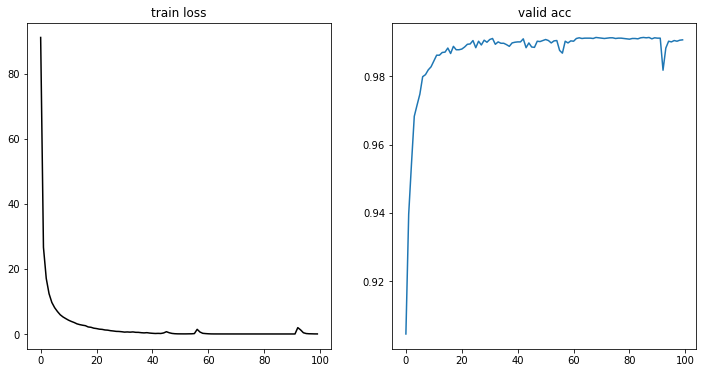

100-th epoch에서는 진척 없음.
현재 검증 데이터의 분류 성공율 최댓값은 99.140%
훈련 종료.
69번째 epoch에서 검증 정답율 최대


In [14]:
tt.train(100)

In [15]:
cnn.accuracy(train_x, train_y)

1.0

In [16]:
cnn.accuracy(valid_x, valid_y)

0.9907

In [17]:
cnn.load('cnnlr5e-4') 
cnn.accuracy(valid_x, valid_y)

Models loaded succesfully


0.9914

In [18]:
test_image = np.load('mnist_test_image.npy')
test_label = np.load('mnist_test_label.npy')

In [19]:
ctr = 0
false_list = []
for i, img in enumerate(test_image):
    guess = cnn.predict(img)
    if guess == test_label[i]:
        ctr +=1
    else:
        false_list.append(i)
print(ctr)
    

9917


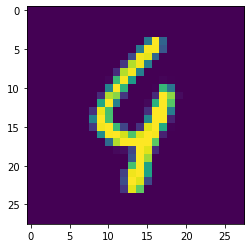

In [23]:
plt.imshow(test_image[false_list[1]])

In [25]:
test_label[false_list[1]]

4

In [26]:
cnn.predict(test_image[false_list[1]])

9